# Проект: Детектор объектов на дороге

## 1. Импорты и глобальные настройки

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import copy
from tqdm.notebook import tqdm
import pandas as pd
import os
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.model_selection import train_test_split


Глобальные настройки

In [2]:
plt.style.use('dark_background')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используем устройство: {device}")

Используем устройство: cuda


## 2. Подготовка данных

### Загрузка данных и первичный анализ

Загрузим аннотации

In [3]:
DATA_DIR = 'data/data/export'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, '_annotations.csv')

annotations_df = pd.read_csv(ANNOTATIONS_FILE)

Посмотрим на структуру

In [4]:
display(annotations_df.head())
annotations_df.info()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,291,247,370,331
1,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,pedestrian,270,235,293,321
2,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,0,266,13,327
3,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,25,258,106,304
4,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,111,259,135,289


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194539 entries, 0 to 194538
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  194539 non-null  object
 1   width     194539 non-null  int64 
 2   height    194539 non-null  int64 
 3   class     194539 non-null  object
 4   xmin      194539 non-null  int64 
 5   ymin      194539 non-null  int64 
 6   xmax      194539 non-null  int64 
 7   ymax      194539 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 11.9+ MB


Подсчитаем количество классов

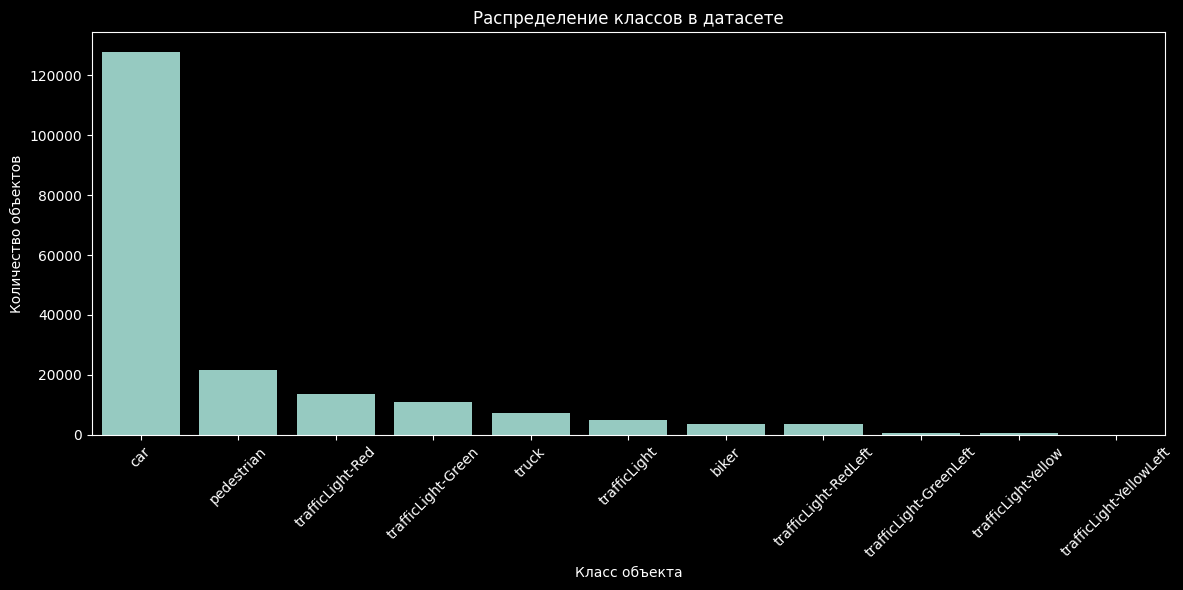

In [5]:
plt.figure(figsize=(12, 6))

class_counts = annotations_df['class'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45)
plt.title('Распределение классов в датасете')
plt.xlabel('Класс объекта')
plt.ylabel('Количество объектов')
plt.tight_layout()

Классовый дисбаланс и избыточная детализация — главные проблемы нашего датасета. Мы имеем огромное количество экземпляров класса 'car' и очень мало экземпляров редких классов, что создает проблему "длинного хвоста" и излишней гранулярности, особенно заметной на примере светофоров.

### Упрощение и очистка данных

Сейчас нам важно не определить цвет светофора, а научить модель его находить, создав единый класс traffic_light для борьбы с классовым дисбалансом и построения надёжного фундамента. На первом этапе решим более простую задачу детекции, а затем перейдём к более сложной задаче классификации цвета.

In [6]:
traffic_classes = ['trafficLight-Red', 'trafficLight', 'trafficLight-Green', 'trafficLight-RedLeft',
                    'trafficLight-GreenLeft', 'trafficLight-Yellow',
                    'trafficLight-YellowLeft']

annotations_df.loc[annotations_df['class'].isin(traffic_classes), 'class'] = 'traffic_light'

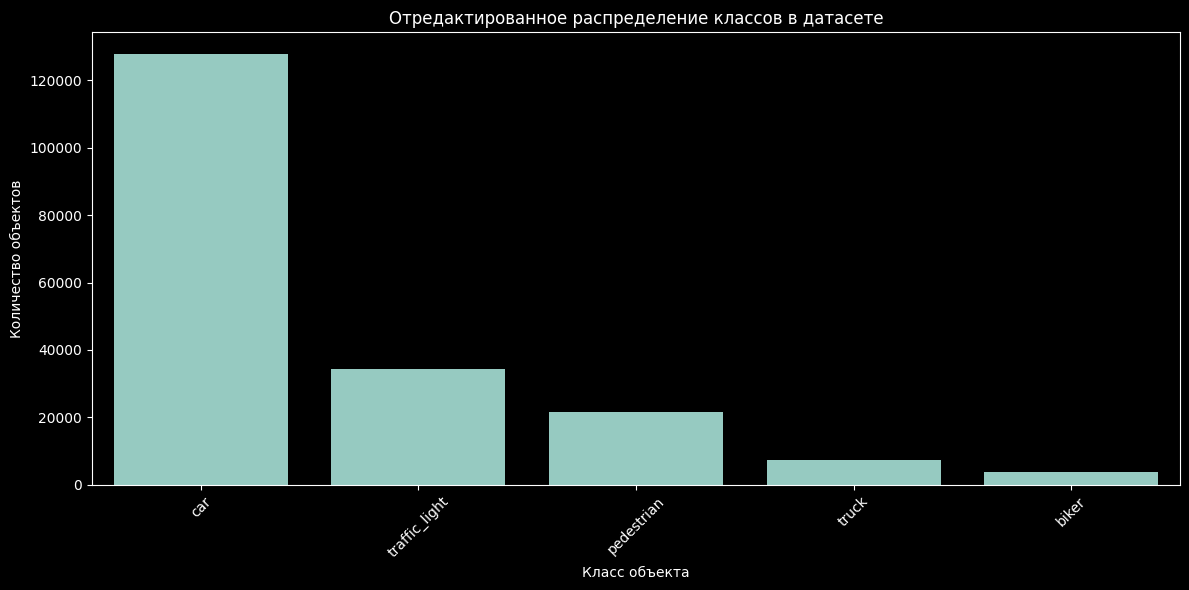

In [7]:
plt.figure(figsize=(12, 6))

class_counts_2 = annotations_df['class'].value_counts()
sns.barplot(x=class_counts_2.index, y=class_counts_2.values)
plt.xticks(rotation=45)
plt.title('Отредактированное распределение классов в датасете')
plt.xlabel('Класс объекта')
plt.ylabel('Количество объектов')
plt.tight_layout()

### Подготовка данных к созданию Dataset

Создадим словарь, который сопоставит каждому уникальному имени класса уникальную числовую метку.

In [8]:
class_names = list(class_counts_2.index)
class_to_int = {name: i + 1 for i, name in enumerate(class_names)}

class_to_int

{'car': 1, 'traffic_light': 2, 'pedestrian': 3, 'truck': 4, 'biker': 5}

Создадим новую колонку class_id в DataFrame

In [9]:
annotations_df['class_id'] = annotations_df['class'].map(class_to_int)
annotations_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,class_id
0,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,291,247,370,331,1
1,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,pedestrian,270,235,293,321,3
2,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,0,266,13,327,1
3,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,25,258,106,304,1
4,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,111,259,135,289,1


Сгруппируем данные в новый датафрейм image_annotations так, чтобы одному изображению соответствовала только одна строка

In [10]:
cols_to_agg = ['xmin', 'ymin', 'xmax', 'ymax', 'class_id']

image_annotations = (
    annotations_df
    .groupby('filename')[cols_to_agg]
    .agg(list)
    .reset_index()
)

image_annotations.head()

,filename,xmin,ymin,xmax,ymax,class_id
0,1478019952686311006_jpg.rf.54e2d12dbabc46be3c7...,"[218, 229, 253, 466]","[243, 246, 245, 206]","[226, 241, 268, 485]","[257, 260, 264, 318]","[4, 1, 1, 3]"
1,1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF...,"[218, 229, 253, 466]","[243, 246, 245, 206]","[226, 241, 268, 485]","[257, 260, 265, 317]","[4, 1, 1, 3]"
2,1478019953180167674_jpg.rf.8a816c9d7e9b423a63e...,"[198, 206, 387, 232]","[246, 251, 218, 250]","[207, 217, 445, 247]","[262, 264, 262, 270]","[4, 1, 4, 1]"
3,1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLT...,"[198, 206, 387, 233]","[246, 251, 218, 250]","[207, 217, 445, 247]","[262, 264, 262, 270]","[4, 1, 4, 1]"
4,1478019953689774621_jpg.rf.2e4b7ae29c3379da128...,"[126, 183, 191, 220, 411, 439]","[251, 242, 247, 248, 209, 213]","[129, 194, 204, 235, 448, 493]","[263, 264, 266, 267, 260, 254]","[3, 4, 1, 1, 1, 1]"


### Создание загрузчиков данных

In [11]:
train_df, val_df = train_test_split(image_annotations, test_size=0.2, random_state=42)

Создадим пайплайн для аугментации в Albumentations, так как аугментации для детекции объектов должны одновременно изменять и изображение, и координаты bounding box'ов

In [12]:
train_transforms = A.Compose(
    [
        A.Resize(height=512, width=512, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(p=0.2),
        A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0, p=1.0),
        A.ToTensorV2(p=1.0)
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

val_transforms = A.Compose(
    [
        A.Resize(height=512, width=512, p=1.0),
        A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0, p=1.0),
        A.ToTensorV2(p=1.0)
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

c:\Users\79104\anaconda3\envs\road_detector\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Определим свой класс Dataset, так как задачи детекции очень вариативны и нет отдельной функции, которая могла бы правильно собрать все наши данные

In [13]:
class RoadObjectDataset(Dataset):
    def __init__(self, annotations_df, image_dir, transforms=None):
        super().__init__()
        self.annotations = annotations_df
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        image_record = self.annotations.iloc[idx]
        image_filename = image_record['filename']

        image_path = os.path.join(self.image_dir, image_filename)

        image = cv2.imread(image_path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        xmins = image_record['xmin']
        ymins = image_record['ymin']
        xmaxs = image_record['xmax']
        ymaxs = image_record['ymax']
        labels = image_record['class_id']

        bboxes = [[xmin, ymin, xmax, ymax] for xmin, ymin, xmax, ymax in zip(xmins, ymins, xmaxs, ymaxs)]
        
        bboxes = np.array(bboxes)
        labels = np.array(labels)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)
            
            image = transformed['image'] 
            
            if len(transformed['bboxes']) > 0:
                bboxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
                labels = torch.tensor(transformed['labels'], dtype=torch.int64)
            else:
                bboxes = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros(0, dtype=torch.int64)

        else:
            image = torch.from_numpy(image).permute(2, 0, 1) / 255.0
            bboxes = torch.tensor(bboxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {'boxes': bboxes, 'labels': labels}

        return image, target

Создадим экземпляры нашего класса для тренировочной и валидационной выборки

In [ ]:
IMAGE_DIR = 'data/data/export' 
train_dataset = RoadObjectDataset(train_df, IMAGE_DIR, train_transforms)
val_dataset = RoadObjectDataset(val_df, IMAGE_DIR, val_transforms)

In [15]:
def collate_fn(batch):
    """
    Правильно "собирает" батч для задачи детекции.
    Возвращает кортеж из списка тензоров изображений и списка словарей target.
    """
    return tuple(zip(*batch))

In [16]:
BATCH_SIZE = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Количество обучающих изображений: {len(train_dataset)}")
print(f"Количество валидационных изображений: {len(val_dataset)}")
print(f"Количество классов: {annotations_df['class'].nunique()}")

Количество обучающих изображений: 21040
Количество валидационных изображений: 5260
Количество классов: 5


### Визуализация изображений с объектами для детекции

Напишем функцию, которая сможет взять тензор изображения и target и нарисовать на картинке bounding box'ы

In [56]:
int_to_class = {v: k for k, v in class_to_int.items()}
print(int_to_class)

{1: 'car', 2: 'traffic_light', 3: 'pedestrian', 4: 'truck', 5: 'biker'}


In [61]:
def visualize_sample(image_tensor, target, int_to_class_map):

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 255).astype(np.uint8)

    image_to_draw = image_np.copy()
    for box, label_id in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box.int().numpy()
        
        label_text = int_to_class_map.get(label_id.item(), 'UNKNOWN')

        cv2.rectangle(image_to_draw, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=2)
        cv2.putText(
            image_to_draw,
            label_text, 
            (xmin, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9,
            (0, 255, 0), 
            2
        )
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image_to_draw)
    plt.axis('off')
    plt.show()

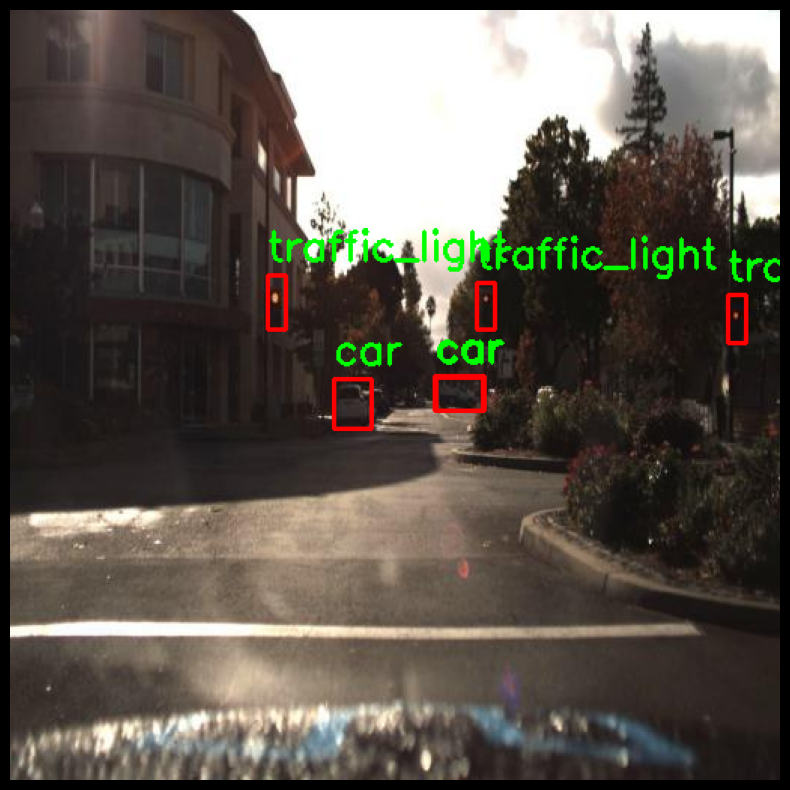

In [62]:
images, targets = next(iter(train_loader))
visualize_sample(images[0], targets[0], int_to_class)

Отлично, все объекты были правильно выделены, а значит:
- Наш Dataset правильно прочитал изображение
- Он правильно извлек аннотации
- Он передал их в Albumentations
- Albumentations применил аугментации и корректно трансформировал bounding box'ы
- Наша функция visualize_sample правильно все отобразила

## 3. Создание и настройка модели

В качестве готовой предобученной модели выберем fasterrcnn_mobilenet_v3_large_fpn - быстрая и достаточно точная. 

Будем обучать модель полностью, так как для нашей задачи, где домен данных (дороги) достаточно сильно отличается от ImageNet, а сама задача (детекция) сложнее простой классификации, дообучение модели целиком - эффективная практика

In [19]:
model = fasterrcnn_mobilenet_v3_large_fpn(weights='DEFAULT')
num_classes = annotations_df['class'].nunique() + 1 
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

Определим оптимизатор модели и scheduler

In [20]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.001, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',      
    factor=0.1,      
    patience=2,
    verbose=True
)

c:\Users\79104\anaconda3\envs\road_detector\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Цикл обучения и валидации

Напишем функции для обучения и валидации модели на 1 эпохе

In [21]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(data_loader, desc='Training')
    for images, targets in progress_bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        loss_value = losses.item()
        total_loss += loss_value
        
        losses.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss_value)
    
    avg_loss = total_loss / len(data_loader)
    print(f"Эпоха обучения завершена. Средний лосс: {avg_loss:.4f}")

    return avg_loss

In [ ]:
def evaluate(model, data_loader, device):
    metric = MeanAveragePrecision(box_format='xyxy', backend='faster_coco_eval').to(device)
    
    total_val_loss = 0.0
    
    progress_bar = tqdm(data_loader, desc="Validation")
    
    with torch.no_grad():
        for images, targets in progress_bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_val_loss += losses.item()
            
            model.eval()
            predictions = model(images)
            
            metric.update(predictions, targets)

    avg_val_loss = total_val_loss / len(data_loader)
    map_results = metric.compute()
    
    final_results = {
        'val_loss': avg_val_loss,
        'map': map_results['map'],
        'map_50': map_results['map_50']
    }
    
    return final_results

Напишем главную функцию обучения

In [24]:
def train_detector_model(model, optimizer, scheduler, num_epochs=10):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_map = 0.0
    
    
    history = {
        'train_loss': [], 
        'val_loss': [], 
        'val_map': [], 
        'val_map_50': []
    }

    for epoch in range(num_epochs):
        print(f'--- Эпоха {epoch + 1}/{num_epochs} ---')

        avg_train_loss = train_one_epoch(model, optimizer, train_loader, device)
        history['train_loss'].append(avg_train_loss)

        val_results = evaluate(model, val_loader, device)
        
        epoch_val_loss = val_results['val_loss']
        epoch_map = val_results['map'].item()
        epoch_map_50 = val_results['map_50'].item()
        
        history['val_loss'].append(epoch_val_loss)
        history['val_map'].append(epoch_map)
        history['val_map_50'].append(epoch_map_50)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        print(f"Val mAP: {epoch_map:.4f} | Val mAP@.50: {epoch_map_50:.4f} | LR: {current_lr:.6f}")
        scheduler.step(epoch_map)


        if epoch_map > best_map:
            print(f"Новый лучший результат! MAP улучшился с {best_map:.4f} до {epoch_map:.4f}. Сохраняем модель.")
            best_map = epoch_map
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_detector_model.pth')
        
        print()

    time_elapsed = time.time() - start_time
    print(f'Обучение завершено за {time_elapsed // 60:.0f}м {time_elapsed % 60:.0f}с')
    print(f'Лучший mAP на валидации: {best_map:4f}')

    model.load_state_dict(best_model_wts)
    
    return model, history

Запускаем обучение

In [25]:
model, history = train_detector_model(model, optimizer, scheduler, num_epochs=10)

--- Эпоха 1/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5868


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5868 | Val Loss: 0.5330
Val mAP: 0.1587 | Val mAP@.50: 0.3646 | LR: 0.001000
Новый лучший результат! MAP улучшился с 0.0000 до 0.1587. Сохраняем модель.

--- Эпоха 2/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5722


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5722 | Val Loss: 0.5026
Val mAP: 0.1724 | Val mAP@.50: 0.3901 | LR: 0.001000
Новый лучший результат! MAP улучшился с 0.1587 до 0.1724. Сохраняем модель.

--- Эпоха 3/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5721


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5721 | Val Loss: 0.5807
Val mAP: 0.1925 | Val mAP@.50: 0.4365 | LR: 0.001000
Новый лучший результат! MAP улучшился с 0.1724 до 0.1925. Сохраняем модель.

--- Эпоха 4/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5705


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5705 | Val Loss: 0.5344
Val mAP: 0.1955 | Val mAP@.50: 0.4420 | LR: 0.001000
Новый лучший результат! MAP улучшился с 0.1925 до 0.1955. Сохраняем модель.

--- Эпоха 5/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5755


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5755 | Val Loss: 0.6036
Val mAP: 0.2550 | Val mAP@.50: 0.5240 | LR: 0.000100
Новый лучший результат! MAP улучшился с 0.1955 до 0.2550. Сохраняем модель.

--- Эпоха 6/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5857


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5857 | Val Loss: 0.5904
Val mAP: 0.2668 | Val mAP@.50: 0.5350 | LR: 0.000100
Новый лучший результат! MAP улучшился с 0.2550 до 0.2668. Сохраняем модель.

--- Эпоха 7/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5874


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5874 | Val Loss: 0.5902
Val mAP: 0.2776 | Val mAP@.50: 0.5541 | LR: 0.000100
Новый лучший результат! MAP улучшился с 0.2668 до 0.2776. Сохраняем модель.

--- Эпоха 8/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5866


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5866 | Val Loss: 0.6169
Val mAP: 0.2858 | Val mAP@.50: 0.5612 | LR: 0.000010
Новый лучший результат! MAP улучшился с 0.2776 до 0.2858. Сохраняем модель.

--- Эпоха 9/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5920


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5920 | Val Loss: 0.6037
Val mAP: 0.2874 | Val mAP@.50: 0.5624 | LR: 0.000010
Новый лучший результат! MAP улучшился с 0.2858 до 0.2874. Сохраняем модель.

--- Эпоха 10/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5919


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5919 | Val Loss: 0.6093
Val mAP: 0.2882 | Val mAP@.50: 0.5649 | LR: 0.000010
Новый лучший результат! MAP улучшился с 0.2874 до 0.2882. Сохраняем модель.

Обучение завершено за 114м 53с
Лучший mAP на валидации: 0.288235


### Визуализация результатов

Построим графики mAP и loss модели на тренировочных и валидационных данных

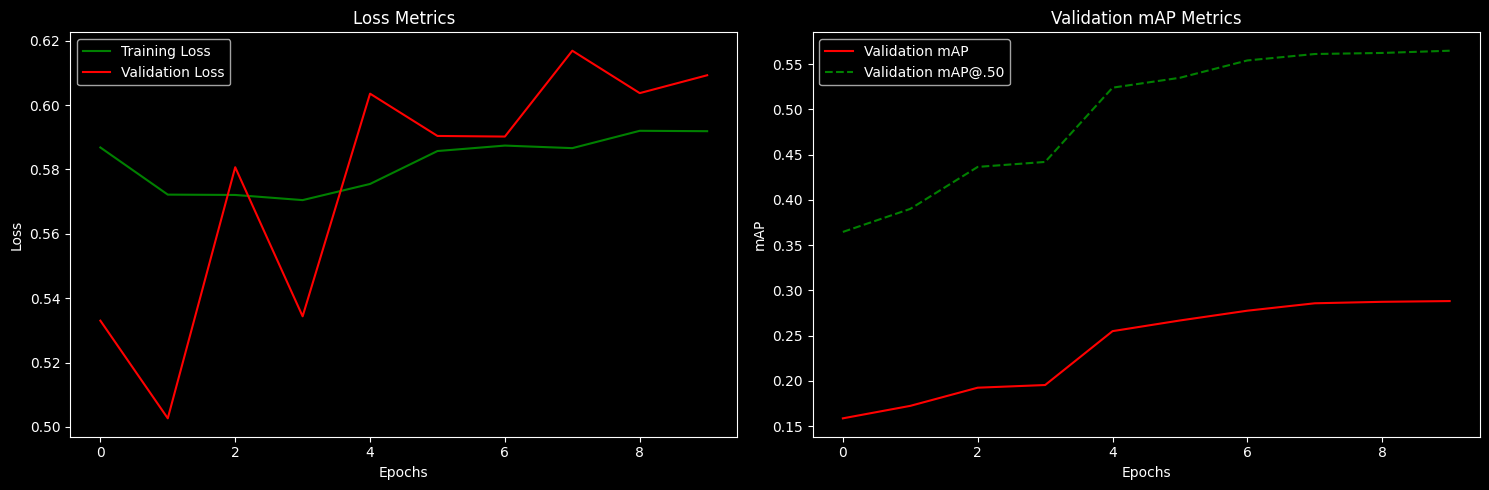

In [27]:
train_loss = history['train_loss']
val_loss = history['val_loss']
val_map = history['val_map']
val_map_50 = history['val_map_50']

epochs_range = range(len(train_loss))

plt.figure(figsize=(15, 5))

# График 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, 'g', label='Training Loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation Loss')
plt.title('Loss Metrics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График 2: Validation mAP
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_map, 'r-', label='Validation mAP')
plt.plot(epochs_range, val_map_50, 'g--', label='Validation mAP@.50')
plt.title('Validation mAP Metrics')
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.legend()

plt.tight_layout()
plt.show()

Какую информацию мы получили из этих графиков:

- С увеличением количества эпох увеличивался и Loss модели(Это может говорить о том, что модель стабильно обучалась и извлекала из тренировочных данных максимум полезной информации, пока не достигла своего предела при текущих настройках)
- Модель не переобучилась
- Увеличивающийся Loss не мешал mAP расти
- На всём протяжении обучения mAP на тренирововчной и валидационной выборке рос
- Модель вышла на плато после 7 эпохи(модель достигла своего пика при текущих гиперпараметрах)
- Финальное значение Validation mAP@.50 находится в районе 0.55-0.57 - это очень хороший результат, который говорит нам о том, что наша модель находит больше половины объектов с приемлемым пересечением

Постараемся добиться лучших результатов, используя fine-tuning модели

### Fine-tuning

Создаем архитектуру модели заново

In [28]:
model_ft = fasterrcnn_mobilenet_v3_large_fpn(weights=None) 
num_classes = annotations_df['class'].nunique() + 1 
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\79104/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:11<00:00, 1.89MB/s]


Загружаем наши лучшие веса

In [29]:
model_ft.load_state_dict(torch.load('best_detector_model.pth'))
model_ft = model_ft.to(device)

C:\Users\79104\AppData\Local\Temp\ipykernel_20292\218480177.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('best_detector_model.pth'

Разморозим только последние несколько блоков backbone'а

In [36]:
for param in model_ft.parameters():
    param.requires_grad = False

for param in model_ft.roi_heads.parameters():
    param.requires_grad = True
for param in model_ft.rpn.parameters():
    param.requires_grad = True

finetune_backbone_params = []
for i, layer in enumerate(model_ft.backbone.body.values()):
    if i >= 14:
        for param in layer.parameters():
            param.requires_grad = True
            finetune_backbone_params.extend(list(layer.parameters()))

Собираем параметры для fine-tuning'а

In [38]:
params_to_update = [
    {'params': model_ft.roi_heads.parameters()},
    {'params': model_ft.rpn.parameters()},
    {'params': finetune_backbone_params, 'lr': 1e-5} 
]

Создаём новый оптимизатор и scheduler

In [41]:
optimizer_ft =  optim.AdamW(params_to_update, lr=1e-4, weight_decay=1e-4)
scheduler_ft = ReduceLROnPlateau(
    optimizer_ft,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True
)

Посмотрим, сколько параметров мы теперь обучаем

In [42]:
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Обучаемых параметров на этапе fine-tuning: {trainable_params}")

Обучаемых параметров на этапе fine-tuning: 16275785


Запускаем обучение

In [43]:
print("\n--- НАЧАЛО ЭТАПА FINE-TUNING ---")
num_epochs_finetune = 10 

model_ft, history_ft = train_detector_model(
    model_ft,
    optimizer_ft,
    scheduler_ft,
    num_epochs=num_epochs_finetune
)

torch.save(model_ft.state_dict(), 'finetuned_detector_model.pth')


--- НАЧАЛО ЭТАПА FINE-TUNING ---
--- Эпоха 1/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5951


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5951 | Val Loss: 0.6136
Val mAP: 0.2857 | Val mAP@.50: 0.5649 | LR: 0.000100
Новый лучший результат! MAP улучшился с 0.0000 до 0.2857. Сохраняем модель.

--- Эпоха 2/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5969


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5969 | Val Loss: 0.6237
Val mAP: 0.2940 | Val mAP@.50: 0.5711 | LR: 0.000100
Новый лучший результат! MAP улучшился с 0.2857 до 0.2940. Сохраняем модель.

--- Эпоха 3/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5917


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5917 | Val Loss: 0.6152
Val mAP: 0.2955 | Val mAP@.50: 0.5781 | LR: 0.000100
Новый лучший результат! MAP улучшился с 0.2940 до 0.2955. Сохраняем модель.

--- Эпоха 4/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5859


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5859 | Val Loss: 0.6092
Val mAP: 0.2982 | Val mAP@.50: 0.5794 | LR: 0.000100
Новый лучший результат! MAP улучшился с 0.2955 до 0.2982. Сохраняем модель.

--- Эпоха 5/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5799


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5799 | Val Loss: 0.5942
Val mAP: 0.3052 | Val mAP@.50: 0.5888 | LR: 0.000010
Новый лучший результат! MAP улучшился с 0.2982 до 0.3052. Сохраняем модель.

--- Эпоха 6/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5749


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5749 | Val Loss: 0.5965
Val mAP: 0.3064 | Val mAP@.50: 0.5894 | LR: 0.000010
Новый лучший результат! MAP улучшился с 0.3052 до 0.3064. Сохраняем модель.

--- Эпоха 7/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5748


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5748 | Val Loss: 0.5939
Val mAP: 0.3074 | Val mAP@.50: 0.5911 | LR: 0.000010
Новый лучший результат! MAP улучшился с 0.3064 до 0.3074. Сохраняем модель.

--- Эпоха 8/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5734


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5734 | Val Loss: 0.5920
Val mAP: 0.3078 | Val mAP@.50: 0.5910 | LR: 0.000001
Новый лучший результат! MAP улучшился с 0.3074 до 0.3078. Сохраняем модель.

--- Эпоха 9/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5732


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5732 | Val Loss: 0.5931
Val mAP: 0.3079 | Val mAP@.50: 0.5907 | LR: 0.000001
Новый лучший результат! MAP улучшился с 0.3078 до 0.3079. Сохраняем модель.

--- Эпоха 10/10 ---


Training:   0%|          | 0/2630 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5735


Validation:   0%|          | 0/658 [00:00<?, ?it/s]

Train Loss: 0.5735 | Val Loss: 0.5929
Val mAP: 0.3083 | Val mAP@.50: 0.5905 | LR: 0.000001
Новый лучший результат! MAP улучшился с 0.3079 до 0.3083. Сохраняем модель.

Обучение завершено за 98м 15с
Лучший mAP на валидации: 0.308315


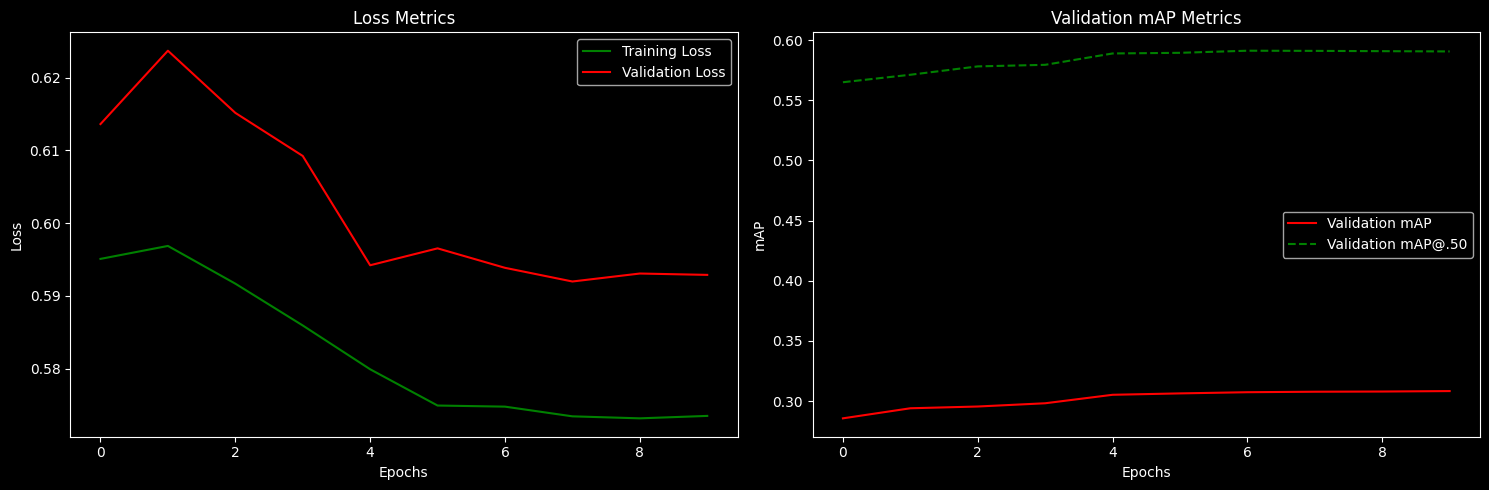

In [44]:
train_loss_ft = history_ft['train_loss']
val_loss_ft = history_ft['val_loss']
val_map_ft = history_ft['val_map']
val_map_50_ft = history_ft['val_map_50']

epochs_range_ft = range(len(train_loss))

plt.figure(figsize=(15, 5))

# График 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range_ft, train_loss_ft, 'g', label='Training Loss')
plt.plot(epochs_range_ft, val_loss_ft, 'r', label='Validation Loss')
plt.title('Loss Metrics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График 2: Validation mAP
plt.subplot(1, 2, 2)
plt.plot(epochs_range_ft, val_map_ft, 'r-', label='Validation mAP')
plt.plot(epochs_range_ft, val_map_50_ft, 'g--', label='Validation mAP@.50')
plt.title('Validation mAP Metrics')
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.legend()

plt.tight_layout()
plt.show()

Мы смогли добиться увеличения качества модели до ~60% mAP@.50. Дальнейшее увеличение количества эпох также повысило бы её точность, но незначительно.

### Визуализация работы модели

Наглядно покажем, как модель обнаруживат объекты

In [45]:
def predict(model, image_tensor, device, confidence_threshold=0.5):
    """
    Подает изображение в модель и получает предсказания
    """
    model.eval()

    with torch.no_grad():
        prediction = model([image_tensor.to(device)])[0]

    boxes = prediction['boxes']
    labels = prediction['labels']
    scores = prediction['scores']

    keep = scores > confidence_threshold

    final_boxes = boxes[keep]
    final_labels = labels[keep]

    result_target = {'boxes': final_boxes.cpu(), 'labels': final_labels.cpu()}
    
    return result_target

Предсказания финальной модели:


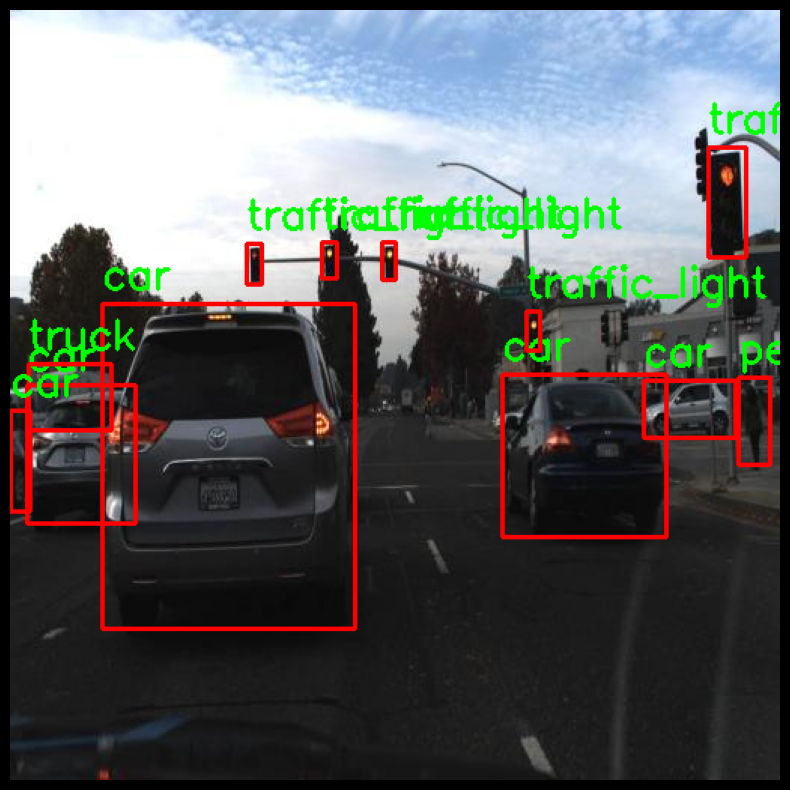

In [79]:
img_tensor, _ = val_dataset[13] 
predicted_target = predict(model_ft, img_tensor, device, confidence_threshold=0.6) 

print("Предсказания финальной модели:")
visualize_sample(img_tensor, predicted_target, int_to_class)

Отлично! Модель правильно инициализировала все объекты на изображении

## Выводы

В рамках данного проекта была успешно разработана и обучена модель глубокого обучения для задачи детекции объектов на дорожных сценах. Весь процесс, от подготовки данных до анализа результатов, был пройден, что позволило получить ценный практический опыт и работающий прототип.

**1. Подготовка данных и разработка пайплайна:**

*   Был использован и проанализирован датасет дорожных сцен, содержащий такие классы, как 'car', 'pedestrian', 'truck', 'biker' и различные типы светофоров.
*   В ходе анализа данных был выявлен сильный классовый дисбаланс и избыточная гранулярность классов (множество типов светофоров). Было принято инженерное решение об **объединении всех классов светофоров в один общий класс 'traffic_light'**, что позволило сбалансировать данные и упростить задачу для модели.
*   Был разработан **полноценный пайплайн предобработки данных**, включающий очистку, фильтрацию и преобразование аннотаций в формат, пригодный для PyTorch.
*   Создан кастомный класс `RoadObjectDataset`, способный эффективно работать с аннотациями в формате bounding box.
*   Интегрирована библиотека `Albumentations` для реализации конвейера аугментаций, что критически важно для улучшения обобщающей способности модели.

**2. Выбор и обучение модели:**

*   В качестве базовой архитектуры была выбрана **Faster R-CNN с легковесным и быстрым backbone'ом MobileNetV3-Large**, предобученная на датасете COCO. Данный выбор представляет собой оптимальный компромисс между скоростью и качеством для прототипирования.
*   Был реализован **двухэтапный процесс обучения**:
    1.  **Основное обучение (5 эпох):** Обучалась только "голова" модели и RPN на "замороженном" backbone. Это позволило быстро получить хороший baseline с `mAP@.50` **~51%**.
    2.  **Fine-tuning (10 эпох):** Были "разморожены" последние слои backbone'а, и обучение было продолжено с более низкой скоростью обучения. Этот этап позволил "дожать" качество модели.
*   В процессе обучения отслеживались метрики `Training Loss`, `Validation Loss` и `Validation mAP`.

**3. Результаты и их анализ:**

*   Финальная, дообученная модель достигла высокого качества на валидационной выборке:
    *   **`mAP@.50` (IoU > 0.5): ~60%**
    *   **`mAP` (строгий): ~31%**
*   Анализ графиков показал, что модель стабильно обучалась, а метрики качества на валидационных данных уверенно росли, что свидетельствует об отсутствии серьезного переобучения.
*   Этап fine-tuning'а доказал свою эффективность, обеспечив прирост `mAP@.50` почти на 10 процентных пунктов по сравнению с базовым обучением.

**Итоговое заключение:**

Проект можно считать полностью успешным. Была создана модель, способная с хорошим качеством детектировать ключевые объекты на дорожных сценах. В ходе проекта были освоены и применены на практике все основные этапы построения решения для задачи Object Detection: от работы с "сырыми" данными до реализации продвинутых техник обучения и анализа результатов. Полученная модель (`finetuned_detector_model.pth`) является качественным артефактом, готовым для дальнейшего использования, например, для развертывания в виде простого веб-сервиса.